# 5. Multimodal characterization of exRNA environment

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spatialdata as sd
from tqdm import tqdm
import troutpy 
import scanpy as sc

In [2]:
xenium_path_cropped = "/media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr"
output_path = "/media/sergio/Discovair_final/analysis_crop"
sdata = sd.read_zarr(xenium_path_cropped)

In [133]:
import spatialdata as sd
import numpy as np
import xarray as xr

def extract_transcript_intensities(sdata: sd.SpatialData,
                                   image_key: str,
                                   scale: str,
                                   transcript_key: str,
                                   extracellular: bool = False,
                                   copy: bool = True) -> sd.SpatialData:
    """
    Extracts image intensities at transcript locations and adds them as a new layer in the SpatialData object.

    Args:
        sdata
            The input SpatialData object.
        image_key
            The key for the image layer in sdata.images.
        scale
            The scale of the image to use.
        transcript_key
            The key for the transcript points in sdata.points.
        extracellular
            Whether to include only extracellular transcripts (default: False). If True, only transcripts where `extracellular` is True are used. If false, all transcripts are used.
        copy
            Whether to create a copy of the SpatialData object (default: True).

    Returns
    -------
        A SpatialData object with the added 'transcripts_image_intensities' layer.  If copy=True, a new SpatialData object is returned. Otherwise, the original sdata object is modified and returned.

    Raises
    ------
        KeyError: If the specified image or transcript key is not found in the SpatialData object.
    """
    try:
        image = sdata.images[image_key][scale]  # Image as xarray.DataArray
        transcripts = sdata.points[transcript_key].compute()  # Transcript coordinates
    except KeyError as e:
        raise KeyError(f"Key not found in sdata: {e}")  # noqa: B904

    imarray = image.image.compute()

    minx = transcripts.x.min()
    maxx = transcripts.x.max()
    transcripts_size_x = maxx - minx
    image_size_x = imarray.shape[2]
    multi_factor_x = image_size_x / transcripts_size_x

    miny = transcripts.y.min()
    maxy = transcripts.y.max()
    transcripts_size_y = maxy - miny
    image_size_y = imarray.shape[1]
    multi_factor_y = image_size_y / transcripts_size_y

    transcripts["x_scaled"] = (transcripts["x"] - minx) * multi_factor_x
    transcripts["y_scaled"] = (transcripts["y"] - miny) * multi_factor_y

    if extracellular:
        transcripts = transcripts[transcripts['extracellular'] == True]  # Select extracellular transcripts
    else:
        transcripts = transcripts

    # Get (x, y) coordinates of transcripts
    xy_positions = np.column_stack((transcripts["x_scaled"], transcripts["y_scaled"]))
    xy_positions_raw = np.column_stack((transcripts["x"], transcripts["y"]))

    # Interpolate or fetch nearest pixel values
    intensities = image.sel(x=xr.DataArray(xy_positions[:, 0], dims="points"),
                            y=xr.DataArray(xy_positions[:, 1], dims="points"),
                            method="nearest")  # Use "linear" for interpolation

    intensity_tab = np.zeros([len(intensities.x.values), 2])
    intensity_tab[:, 0] = intensities.x.values
    intensity_tab[:, 1] = intensities.y.values

    ad_data = intensities.image.values.transpose()
    if ad_data.ndim == 2: # Check if it is a 2D image
        ad = sc.AnnData(ad_data)
        ad.var.index = intensities.c.values
    else: # If not, assume it is a 3D image and flatten the last dimension
        ad = sc.AnnData(ad_data.reshape(ad_data.shape[0], -1))
        ad.var.index = [f"{c}_{z}" for c in intensities.c.values for z in range(ad_data.shape[2])] # Create combined channel and z-slice names.

    ad.obs['feature_name'] = list(transcripts['feature_name'])  # Add feature names
    ad.obsm['spatial'] = xy_positions_raw  # Add raw spatial coordinates

    # Add the AnnData object as a new spatial data object
    sdata['image_intensity_of_transcripts']= ad

    return sdata if copy else None

In [135]:
extract_transcript_intensities(sdata,image_key='morphology_focus',scale='scale0',transcript_key='transcripts', extracellular = True,copy = False)

In [136]:
sdata

SpatialData object, with associated Zarr store: /media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr
├── Images
│     └── 'morphology_focus': DataTree[cyx] (5, 3000, 5000), (5, 1500, 2500), (5, 750, 1250), (5, 375, 625), (5, 188, 312)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (3000, 5000), (1500, 2500), (750, 1250), (375, 625), (188, 312)
│     └── 'nucleus_labels': DataTree[yx] (3000, 5000), (1500, 2500), (750, 1250), (375, 625), (188, 312)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 17) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (1762, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (1722, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (1750, 1) (2D shapes)
└── Tables
      ├── 'image_intensity_of_transcripts': AnnData (4298397, 5)
      ├── 'segmentation_free_table': AnnData (2114819, 13035)
      ├── 'source_score': AnnData (834299, 10)
      ├── 'table': AnnData (1703, 

In [ ]:
import numpy as np
import spatialdata as sd
import xarray as xr

# input should consist of image layer, here morphology focus, scale, transcripts, wether to compute extracellular or all, x and y position, and copy. 

# Extract image and transcript positions
image = sdata.images["morphology_focus"]  # Image as xarray.DataArray
transcripts = sdata.points["transcripts"]  # Transcript coordinates

imarray = sdata.images["morphology_focus"]["scale0"].image.compute()
chnames = list(sdata.images["morphology_focus"]["scale0"].image.c.values)
transcripts = sdata.points["transcripts"].compute()

minx = transcripts.x.min()
maxx = transcripts.x.max()
transcripts_size_x = maxx - minx
image_size_x = imarray.shape[2]
multi_factor_x = image_size_x / transcripts_size_x

miny = transcripts.y.min()
maxy = transcripts.y.max()
transcripts_size_y = maxy - miny
image_size_y = imarray.shape[1]
multi_factor_y = image_size_y / transcripts_size_y

transcripts["x_scaled"] = (transcripts["x"] - minx) * multi_factor_x
transcripts["y_scaled"] = (transcripts["y"] - miny) * multi_factor_y


transcripts=transcripts[transcripts['extracellular']==False]

# Get (x, y) coordinates of transcripts
xy_positions = np.column_stack((transcripts["x_scaled"], transcripts["y_scaled"]))
xy_positions_raw = np.column_stack((transcripts["x"], transcripts["y"]))

# Interpolate or fetch nearest pixel values
intensities = image.sel(x=xr.DataArray(xy_positions[:, 0], dims="points"),
                        y=xr.DataArray(xy_positions[:, 1], dims="points"),
                        method="nearest")  # Use "linear" for interpolation

intensity_tab=np.zeros([len(intensities['scale0'].x.values),2])
intensity_tab[:,0]=intensities['scale0'].x.values
intensity_tab[:,1]=intensities['scale0'].y.values

ad=sc.AnnData(intensities['scale0'].image.values.transpose())
ad.var.index=intensities['scale0'].c.values
ad.obs['feature_name']=list(transcripts['feature_name']) # maybe add other folders?
ad.obsm['spatial']=xy_positions_raw# intensity_tab

# save it as a new layer in sdata, called ['transcripts_image_intensities'], return sdata if copy=True 


In [127]:
ad.obs['feature_name']=list(transcripts['feature_name']) # maybe add other folders?

In [88]:
ad2=sc.pp.subsample(ad,0.01, copy=True)

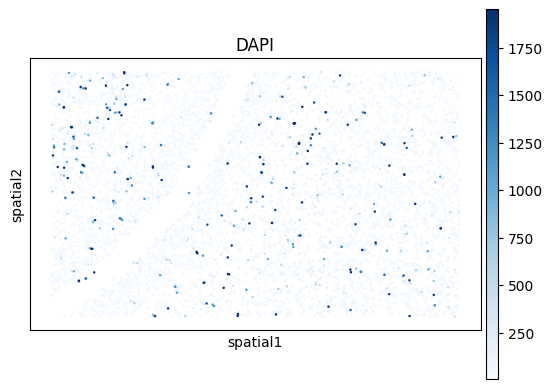

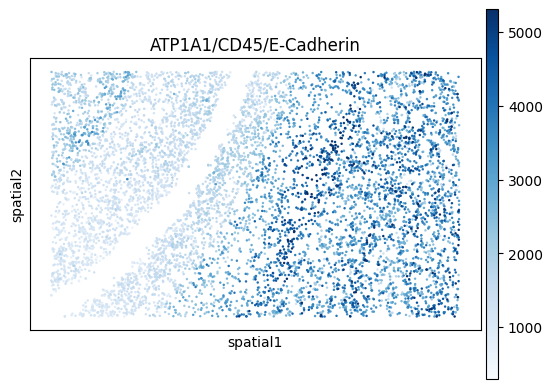

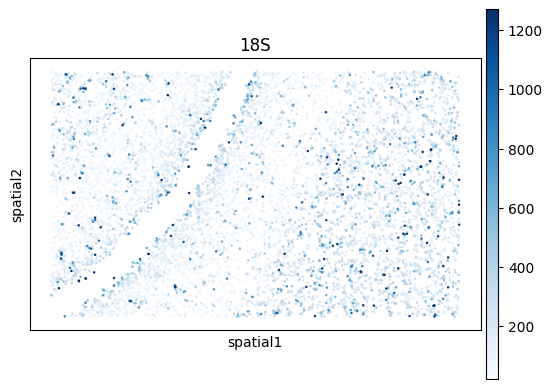

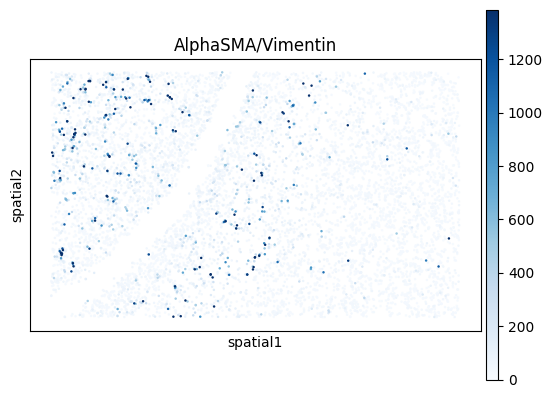

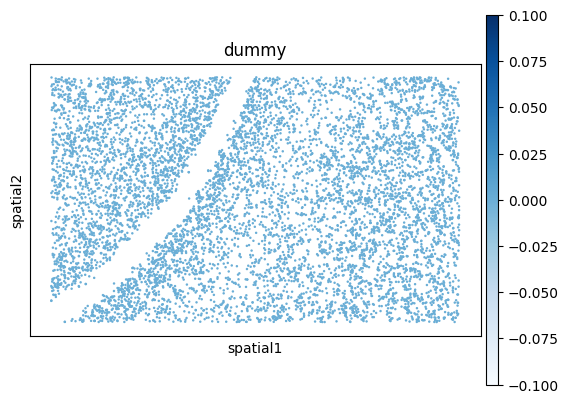

In [89]:
for channel in ad2.var.index:
    sc.pl.spatial(ad2,color=channel,spot_size=30,cmap='Blues',vmax='p99')

In [128]:
genes_selected=sdata['xrna_metadata'].var.index[sdata['xrna_metadata'].var['logfoldratio_over_noise']>4]
ad2=ad[ad.obs['feature_name'].isin(genes_selected)]

In [121]:
sc.pp.log1p(ad2)

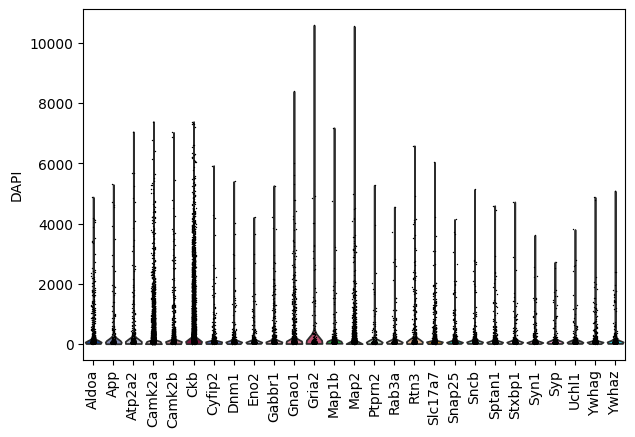

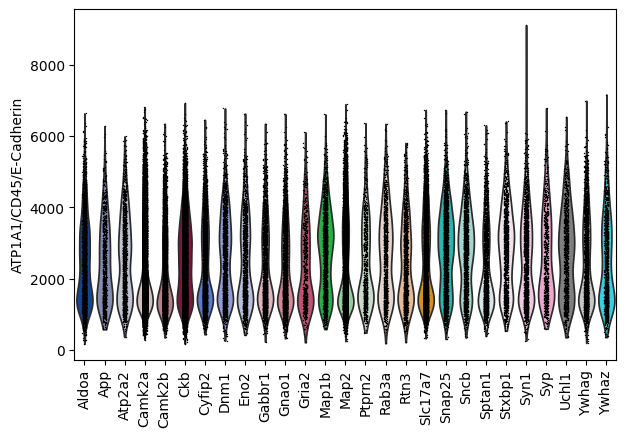

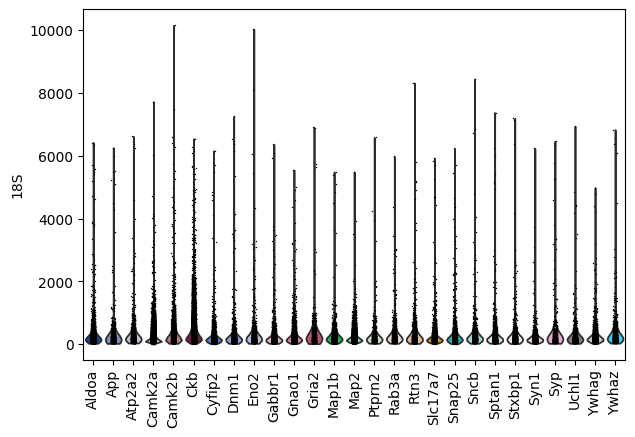

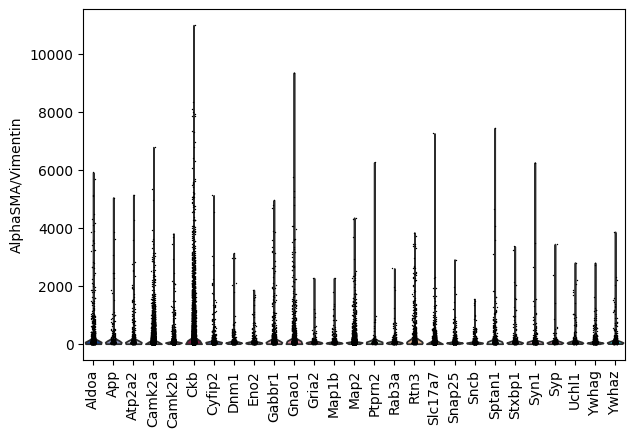

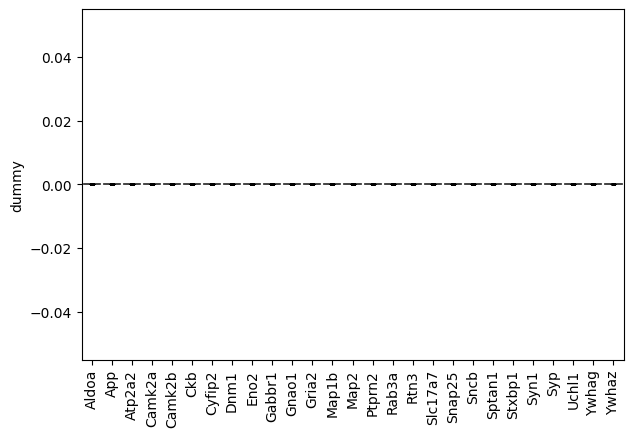

In [129]:
for g in ad.var.index:
    sc.pl.violin(ad2,keys=g,groupby='feature_name',rotation=90,log=False)

In [ ]:
# Add intensities to the transcripts dataframe
sdata.points["transcripts"]["intensity"] = intensities.values


In [ ]:
intensities.values

In [12]:
sdata_im = sdata.aggregate(values="morphology_focus", by="grid_squares", agg_func="mean")

NotImplementedError: Cannot aggregate <class 'spatialdata.models.models.Image2DModel'> by <class 'spatialdata.models.models.ShapesModel'>

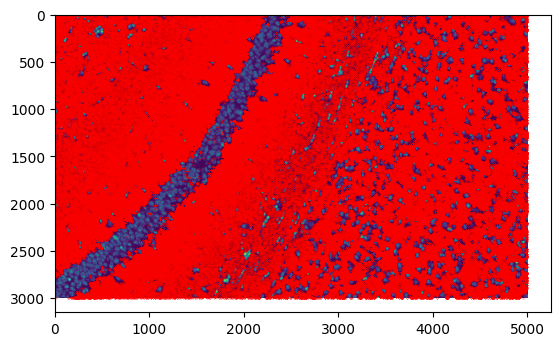

In [64]:
plt.imshow(imarray[0, :, :])
plt.scatter(transcripts.x_scaled, transcripts.y_scaled, s=0.01, color="red")

In [ ]:
import numpy as np
from scipy.ndimage import gaussian_filter, zoom


# Example: Assuming `data_array` is your xArray DataArray with dims (channels, height, width)
def process_xarray(data_array, sigma=5, downsize_factor=0.1):
    """
    Processes a 3D xarray by applying Gaussian smoothing and downscaling on each 2D slice.

    Parameters
    ----------
    - data_array: xarray.DataArray
        A 3D xarray where the first dimension represents slices, and the next two dimensions
        represent 2D spatial data.
    - sigma: float, optional (default=5)
        The standard deviation for the Gaussian kernel used in smoothing.
    - downsize_factor: float, optional (default=0.1)
        The factor by which each 2D slice is resized during downscaling.

    Returns
    -------
    - smoothed_and_downsized: numpy.ndarray
        A 3D numpy array with processed slices, where the first dimension corresponds to
        the original slicing dimension, and the remaining dimensions are the downsized
        2D spatial data.

    Notes
    -----
    - The function loops through each slice of the input data, applies Gaussian smoothing,
      downsizes the smoothed array, and stacks the results back into a single 3D array.
    - Ensure that `data_array` has the correct shape and data types for processing.
    """
    processed_slices = []

    for i in range(data_array.shape[0]):  # Loop over the first dimension
        slice_2d = data_array[i, :, :].values  # Extract the 2D slice

        # Apply KDE (Gaussian smoothing)
        smoothed = gaussian_filter(slice_2d, sigma=sigma)

        # Downsize the array
        downscaled = zoom(smoothed, downsize_factor)

        processed_slices.append(downscaled)

    smoothed_and_downsized = np.stack(processed_slices, axis=0)
    return smoothed_and_downsized


# Example usage
# Assuming your xArray is named `image_array`
smoothed_and_downsized = process_xarray(imarray, sigma=5, downsize_factor=0.5)

# Check the new shape
print(smoothed_and_downsized.shape)

(5, 1500, 2500)


# Continue analysis

In [ ]:
allg = []
for indi in tqdm(transcripts.index):
    allg.append(imarray[:, int(transcripts.loc[indi, "y_scaled"]) - 1, int(transcripts.loc[indi, "x_scaled"]) - 1])

100%|██████████| 703261/703261 [01:54<00:00, 6168.38it/s]


In [68]:
from tqdm import tqdm

# Initialize a list to hold the pixel intensities for all transcripts
allg = []

for indi in tqdm(transcripts.index):
    # Get the x and y coordinates from the DataFrame
    y_coord = int(transcripts.loc[indi, "y_scaled"])
    x_coord = int(transcripts.loc[indi, "x_scaled"])

    # Ensure coordinates are within the bounds of the image array
    if 0 <= y_coord < imarray.shape[1] and 0 <= x_coord < imarray.shape[2]:
        # Extract the pixel intensity for all channels at the given coordinates
        pixel_values = imarray[:, y_coord, x_coord]  # Extract for all channels
        allg.append(pixel_values)
    else:
        # Handle out-of-bound coordinates, if needed
        allg.append([np.nan] * imarray.shape[0])  # Create a list of NaNs for each channel

# Convert the list of pixel intensities into a NumPy array for easier manipulation
pixel_intensities = np.array(allg)

# Add each channel's pixel intensity as a separate column in the transcripts DataFrame
for i in range(pixel_intensities.shape[1]):  # Iterate over the number of channels
    transcripts[chnames[i]] = pixel_intensities[:, i]

# The transcripts DataFrame now has a column for each channel's intensity

100%|██████████| 703261/703261 [01:56<00:00, 6021.10it/s]


In [ ]:
tran2 = transcripts.loc[:, chnames + ["feature_name"]]
tran2["feature_name"] = tran2["feature_name"].astype(str)
mean_intensity = tran2.groupby("feature_name").mean()

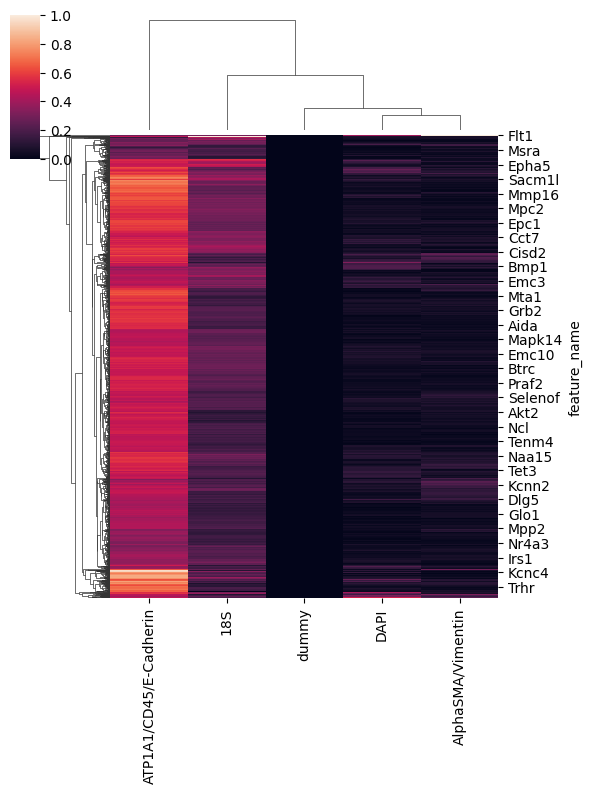

In [84]:
## turn into plotting
mean_intensity_norm = mean_intensity.subtract(mean_intensity.min(axis=0), axis=1)
mean_intensity_norm = mean_intensity_norm.div(mean_intensity_norm.max(axis=0), axis=1)
sns.clustermap(mean_intensity_norm.fillna(0).astype(float), figsize=(6, 8))

<Axes: xlabel='ATP1A1/CD45/E-Cadherin', ylabel='feature_name'>

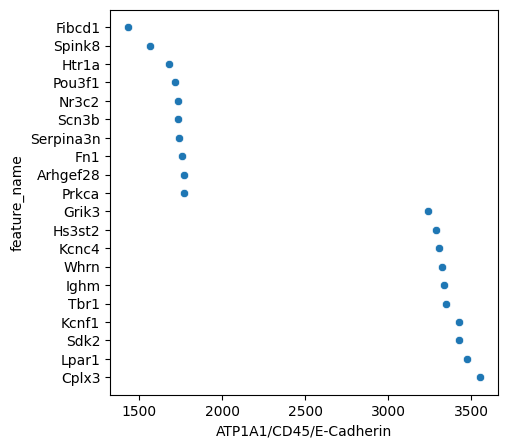

In [94]:
selection = "ATP1A1/CD45/E-Cadherin"
mean_intensity_sorted = mean_intensity.sort_values(by=selection)
intensity_edges = pd.concat([mean_intensity_sorted.head(10), mean_intensity_sorted.tail(10)])
plt.figure(figsize=(5, 5))
sns.scatterplot(y=intensity_edges.index, x=intensity_edges[selection])

<Axes: xlabel='AlphaSMA/Vimentin', ylabel='feature_name'>

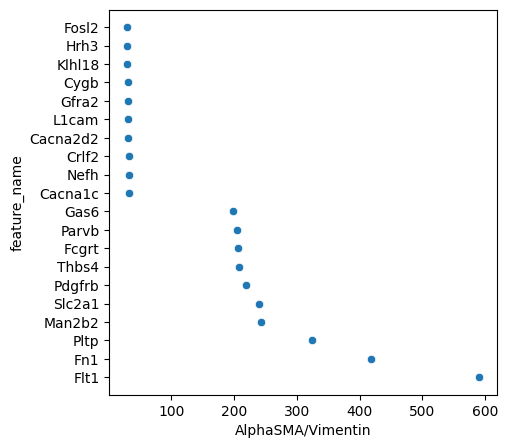

In [95]:
selection = "AlphaSMA/Vimentin"
mean_intensity_sorted = mean_intensity.sort_values(by=selection)
intensity_edges = pd.concat([mean_intensity_sorted.head(10), mean_intensity_sorted.tail(10)])
plt.figure(figsize=(5, 5))
sns.scatterplot(y=intensity_edges.index, x=intensity_edges[selection])